# Grid Search and Model Selection

In [1]:
default_wrkspc = dir()

In [2]:
%%bash
echo "Current branch"
git branch

Current branch
* explore_appr_retr
  master


In [3]:
%load_ext watermark
%watermark

2020-10-08T23:54:17-04:00

CPython 3.6.9
IPython 7.16.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-1093-oem
machine    : x86_64
processor  : x86_64
CPU cores  : 20
interpreter: 64bit


In [4]:
from src.preprocess.dataset import *
from src.models.model_selection import classifier, run_majority_vote, MyGridSearchCV
import os
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='paper', style='whitegrid', 
              palette='deep', font='sans-serif', 
              font_scale=1.25, color_codes=True, rc=None)
%matplotlib inline

## Load Data 

In [5]:
path = '/home/climbach/approach-retreat/data/raw/00a-ROI316_withShiftedSegments.pkl'
dataset = Dataset(path)
dataset.load()

print('Number of subjects: ',len(dataset.sid()))
print('\n')
print('Subject IDs:\n', dataset.sid())
print('\n')
print('Single subject data shape (timepoints, ROIs, trials*6):', dataset.data['CON031']['data'].shape) #

Number of subjects:  61


Subject IDs:
 ['CON031', 'CON021', 'CON022', 'CON030', 'CON023', 'CON025', 'CON016', 'CON053', 'CON052', 'CON089', 'CON020', 'CON033', 'CON019', 'CON084', 'CON027', 'CON049', 'CON028', 'CON026', 'CON054', 'CON034', 'CON036', 'CON058', 'CON056', 'CON075', 'CON072', 'CON055', 'CON061', 'CON057', 'CON067', 'CON064', 'CON068', 'CON059', 'CON051', 'CON078', 'CON077', 'CON066', 'CON098', 'CON076', 'CON073', 'CON085', 'CON091', 'CON090', 'CON082', 'CON121', 'CON097', 'CON101', 'CON092', 'CON103', 'CON102', 'CON099', 'CON096', 'CON106', 'CON110', 'CON119', 'CON118', 'CON116', 'CON114', 'CON113', 'CON123', 'CON120', 'CON125']


Single subject data shape (timepoints, ROIs, trials*6): (14, 316, 222)


Number of `timepoints` and `ROIs` are consistent across subjects. Number of `trials` can vary across subjects.

## Reorganize the data

Every trial consists of 14 timepoints. First 7 timepoints reflect __approach__ period and later 7 reflect __retreat__ period.
Trials are split accordingly and given appropriate labels (approach = 0, retreat = 1). 

In [6]:
dataset_df = organize_dataset(dataset.data)
dataset_df.head()

,participant,trial,data,label
0,CON031,0,"[[0.641909009960325, 0.0788363590406541, -0.04...",0
1,CON031,0,"[[-0.8210910351920893, -1.0944066893755182, -0...",1
0,CON031,1,"[[0.8032866261272865, 0.7311608513515205, 0.17...",0
1,CON031,1,"[[1.1776041685655705, 1.0867125807062854, 1.18...",1
0,CON031,2,"[[-0.3909084241596723, -0.14129164235627137, -...",0


## Train test split

In [7]:
dataset.train_test_split_sid()
X_train, y_train = query_dataset(dataset_df,dataset.train_idx)
X_test, y_test = query_dataset(dataset_df,dataset.test_idx)

## Perform Grid Sreach

In [8]:
# Define the parameter grid for grid search
grid_search_out_path = "../../models/grid_search_results.pkl"
if os.path.isfile(grid_search_out_path):
    with open(grid_search_out_path,"rb") as f:
        results, param_grid = pkl.load(f)
else:
    params = {'L2':[0,0.001,0.003,0.01,0.03],
          'dropout':[0, 0.1, 0.2, 0.3, 0.4],
          'lr':[0.001,0.003,0.006]}
    grid_search = MyGridSearchCV()
    grid_search.fit(dataset_df, dataset.train_idx[:4], classifier, params,cv=3, n_models=2)
    results = grid_search.results
    param_grid = grid_search.param_grid
    
    # Save the results and parameter grid in as pickle file
    #with open('../models/grid_search_results.pkl',"wb") as f:
    #    pkl.dump([results,param_grid],f)

In [9]:
table = pd.DataFrame.from_dict({(i,j,k): results[i][j][k] for i in results.keys() for j in results[i].keys() for k in results[i][j].keys()}).T
table.reset_index(inplace=True)
table.rename(columns={'level_0':'model','level_1':'fold','level_2':'set',0:'acc'},inplace=True)
table['mod_num'] = table.model.str[5:].astype(int)

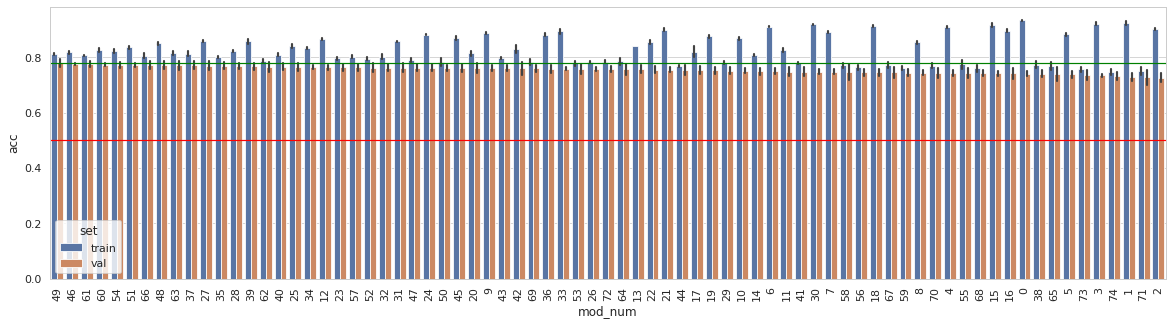

In [10]:
order = table[table['set']=='val'].groupby('mod_num')['acc'].mean().sort_values(ascending = False).index
plt.figure(figsize=(20,5))
sns.barplot(x='mod_num',y='acc',hue='set',ci='sd',data=table,palette=['C0','C1'],order=order)
plt.axhline(0.5,c='red')
plt.axhline(table[table['set']=='val'].groupby(['mod_num'])['acc'].mean().max(),c='green')
_=plt.xticks(rotation=90)

## Final Model

In [11]:
model_path = "../../models/CustomGRU_ROI316_withShiftedSegments.h5"
if os.path.isfile(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    params = {'l2': 0.001, 'dropout': 0.4, 'lr': 0.001}
    model = classifier(X_train,y_train,params['L2'],params['dropout'],params['lr'])
    #model.save(model_path)

In [12]:
print('Training Accuracy:')
model.evaluate(X_train,y_train)
print('Validation Accuracy:')
model.evaluate(X_test,y_test)

Training Accuracy:
708/708 [==============================] - 10s 13ms/step - loss: 0.4208 - acc: 0.8312
Validation Accuracy:
309/309 [==============================] - 4s 13ms/step - loss: 0.4946 - acc: 0.7861


[0.4945836365222931, 0.7861043810844421]